# West Nile Virus in Chicago: Merge Data & Feature Engineering

## Content
---

- [Locations](../code/99_Locations.ipynb)
- [Data Cleaning Summary](../code/01_Data_Cleaning.ipynb) 
- [Train-test Investigation](../code/01a_Train_Test_Investigation.ipynb) 
- [Weather Investigation](../code/01b_Weather_Investigation.ipynb) 
- [Spray Investigation](../code/01c_Spray_Investigation.ipynb) 
- [Feature Engineering](../code/02a_Feature_Engineering.ipynb) **Current Notebook**
- [Combined EDA and Preprocessing](../code/02b_Combined_EDA_and_Preprocessing.ipynb)
- [Model Tuning & Conclusion](../code/03_Model_Tuning_&_Conclusion.ipynb)

We proceed with the combining of our cleaned datasets via concatenation and feature engineering, so as to facilitate the analysis of trap data alongside weather and spray information in a combined and aggregated manner.

## Import all necessary libraries

In [ ]:
!pip install geopy
import geopy.distance as gpd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.spatial import distance

## Read in all cleaned datasets

In [ ]:
train_cleaned = pd.read_csv('../assets/cleaned_train.csv')
train_cleaned.loc[:,'Date'] = pd.to_datetime(train_cleaned.loc[:,'Date'], format='%Y-%m-%d', errors='raise')
train_cleaned.head(3)

,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,NumMosquitos_sum
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0
2,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0,1.0


In [ ]:
test_cleaned = pd.read_csv('../assets/test.csv')
test_cleaned.loc[:,'Date'] = pd.to_datetime(test_cleaned.loc[:,'Date'], format='%Y-%m-%d', errors='raise')
test_cleaned.head(3)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [ ]:
weather_cleaned = pd.read_csv('../assets/weather_cleaned.csv')
weather_cleaned.loc[:,'Date'] = pd.to_datetime(weather_cleaned.loc[:,'Date'], format='%Y-%m-%d', errors='raise')
weather_cleaned.head(3)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum_GR,CodeSum_HZ,CodeSum_MIFG,CodeSum_RA,CodeSum_SN,CodeSum_SQ,CodeSum_TS,CodeSum_TSRA,CodeSum_VCFG,CodeSum_VCTS
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0,0,0,0,0,0,0,0,0,0
1,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2007-05-03,66,46,56,2,40,48,9,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
weather_cleaned.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Sunrise_datetime',
       'Sunset_datetime', 'CodeSum_BCFG', 'CodeSum_BR', 'CodeSum_DZ',
       'CodeSum_FG', 'CodeSum_FG+', 'CodeSum_FU', 'CodeSum_GR', 'CodeSum_HZ',
       'CodeSum_MIFG', 'CodeSum_RA', 'CodeSum_SN', 'CodeSum_SQ', 'CodeSum_TS',
       'CodeSum_TSRA', 'CodeSum_VCFG', 'CodeSum_VCTS'],
      dtype='object')

In [ ]:
spray_cleaned = pd.read_csv('../assets/spray_cleaned.csv')
spray_cleaned.loc[:,'Date'] = pd.to_datetime(spray_cleaned.loc[:,'Date'], format='%Y-%m-%d', errors='raise')
spray_cleaned.head(3)

,Date,Time,Latitude,Longitude,7Daysfterspray,14Daysfterspray,21Daysfterspray
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011-09-05,2011-09-12,2011-09-19
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011-09-05,2011-09-12,2011-09-19
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011-09-05,2011-09-12,2011-09-19


## Feature Engineering on `train` dataset

In [ ]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7370 entries, 0 to 7369
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7370 non-null   datetime64[ns]
 1   Species           7370 non-null   object        
 2   Block             7370 non-null   int64         
 3   Street            7370 non-null   object        
 4   Trap              7370 non-null   object        
 5   Latitude          7370 non-null   float64       
 6   Longitude         7370 non-null   float64       
 7   WnvPresent        7370 non-null   int64         
 8   NumMosquitos_sum  7370 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 518.3+ KB


### Create dummy columns for *Species*

#### Perform get_dummies function on both train and test datasets

In [ ]:
train_species_dummies = pd.get_dummies(data=train_cleaned.loc[:,'Species'], prefix='species')

test_species_dummies = pd.get_dummies(data=test_cleaned.loc[:,'Species'], prefix='species')

#### Ensure both datasets has same dummy columns

In [ ]:
for col1 in test_species_dummies.columns:
    if col1 not in train_species_dummies.columns:
        train_species_dummies.loc[:, col1] = 0

for col2 in train_species_dummies.columns:
    if col2 not in test_species_dummies.columns:
        test_species_dummies.loc[:, col2] = 0

#### Process column names

In [ ]:
train_species_dummies.columns = [c.lower().replace(' ', '_').replace('/', '_') for c in train_species_dummies.columns]

test_species_dummies.columns = [c.lower().replace(' ', '_').replace('/', '_') for c in test_species_dummies.columns]

#### Integrate dummy columns back to respective datasets

In [ ]:
train_cleaned = pd.concat([train_cleaned, train_species_dummies], axis=1)

test_cleaned = pd.concat([test_cleaned, test_species_dummies], axis=1)

#### Inspect datasets

In [ ]:
train_cleaned.head(2)

,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,NumMosquitos_sum,species_culex_erraticus,species_culex_pipiens,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,0,1.0,0,0,1,0,0,0,0,0
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,0,1.0,0,0,0,1,0,0,0,0


In [ ]:
test_cleaned.head(2)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,species_culex_erraticus,species_culex_pipiens,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,1,0,0,0,0,0
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,0,1,0,0,0,0


### Feature engineering on *Date* column

#### Create *month_of_year* column

In [ ]:
train_cleaned.loc[:, 'month_of_year'] = pd.DatetimeIndex(train_cleaned.loc[:, 'Date']).month
test_cleaned.loc[:, 'month_of_year'] = pd.DatetimeIndex(test_cleaned.loc[:, 'Date']).month

#### Create week_of_year column

In [ ]:
train_cleaned.loc[:, 'week_of_year'] = train_cleaned.loc[:, 'Date'].dt.isocalendar().week
test_cleaned.loc[:, 'week_of_year'] = test_cleaned.loc[:, 'Date'].dt.isocalendar().week

#### Create year_and_month column

In [ ]:
train_cleaned.loc[:, 'year_and_month'] = train_cleaned.loc[:, 'Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
test_cleaned.loc[:, 'year_and_month'] = test_cleaned.loc[:, 'Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

#### Create year column

In [ ]:
train_cleaned.loc[:,'year'] = train_cleaned.loc[:,'Date'].dt.year
test_cleaned.loc[:,'year'] = test_cleaned.loc[:,'Date'].dt.year

#### Inspect datasets

In [ ]:
train_cleaned.head(3)

,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,NumMosquitos_sum,species_culex_erraticus,...,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,year_and_month,year
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0,0,...,1,0,0,0,0,0,5,22,2007-05,2007
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0,0,...,0,1,0,0,0,0,5,22,2007-05,2007
2,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0,1.0,0,...,0,1,0,0,0,0,5,22,2007-05,2007


In [ ]:
test_cleaned.head(3)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,year_and_month,year
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,1,0,0,0,0,0,6,24,2008-06,2008
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,1,0,0,0,0,6,24,2008-06,2008
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0,0,0,0,0,6,24,2008-06,2008


In [ ]:
test_cleaned.drop(columns=['Address', 'AddressNumberAndStreet'], inplace=True, errors='ignore')

In [ ]:
print('train_cleaned shape: {}'.format(train_cleaned.shape))
print('test_cleaned shape: {}'.format(test_cleaned.shape))

train_cleaned shape: (7370, 21)
test_cleaned shape: (116293, 21)


## Combine `train` and `weather` datasets

Combining both these datasets would allow us to look closer at possible patterns arising from mosquito and trap data, in relation to the prevailing weather elements.

The common feature in both datasets is *Date*, so we are able to associate record in `train_cleaned` captured on a certain date with a weather forcast on the same day. However, we have weather information from 2 stations, both being approximately 20 kilometers apart from each other based on their coordinate information. Each `train_cleaned` record also contains the *Latitude* and *Longitude* values, hence we have decided to associate the weather data of the station in closer proximity with the respective trap location. This can be determined by Euclidean distance comparison of both weather stations to the targeted trap location.

### Define helper function to determine selected weather station

In [ ]:
# Helper function would take in a row of train_cleaned record, then utilise the lat/long info to 
# calculate euclidean distance and ultimately pick the closer station as reference
#
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

def get_weather_station(row):
    # CHICAGO O'HARE
    stn1_lat = 41.995
    stn1_long = -87.933
    
    # MIDWAY
    stn2_lat = 41.786
    stn2_long = -87.752

    stn1_location = (stn1_lat, stn1_long)
    stn2_location = (stn2_lat, stn2_long)

    record_location = (row['Latitude'], row['Longitude'])
    
    # euclidean function in scipy
    dst_to_stn1 = distance.euclidean(u=stn1_location, v=record_location)
    dst_to_stn2 = distance.euclidean(u=stn2_location, v=record_location)

    # if distance of record to stn-1 is smaller than distance 
    # of record to stn-2, return stn-1 as reference.
    if dst_to_stn1 < dst_to_stn2:
        return 1
    else:
        return 2

### Apply helper function to `train_cleaned` and `test_cleaned` datasets

In [ ]:
train_cleaned.loc[:,'reference_weather_stn'] = train_cleaned.apply(get_weather_station, axis=1)
train_cleaned.head(3)

,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,NumMosquitos_sum,species_culex_erraticus,...,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,year_and_month,year,reference_weather_stn
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0,0,...,0,0,0,0,0,5,22,2007-05,2007,1
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0,0,...,1,0,0,0,0,5,22,2007-05,2007,1
2,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0,1.0,0,...,1,0,0,0,0,5,22,2007-05,2007,1


In [ ]:
train_cleaned.loc[:,'reference_weather_stn'].value_counts()

2    5963
1    1407
Name: reference_weather_stn, dtype: int64

In [ ]:
test_cleaned.loc[:,'reference_weather_stn'] = test_cleaned.apply(get_weather_station, axis=1)
test_cleaned.head(3)

,Id,Date,Species,Block,Street,Trap,Latitude,Longitude,AddressAccuracy,species_culex_erraticus,...,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,year_and_month,year,reference_weather_stn
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,0,...,0,0,0,0,0,6,24,2008-06,2008,1
1,2,2008-06-11,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,0,...,1,0,0,0,0,6,24,2008-06,2008,1
2,3,2008-06-11,CULEX PIPIENS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,0,...,0,0,0,0,0,6,24,2008-06,2008,1


In [ ]:
test_cleaned.loc[:,'reference_weather_stn'].value_counts()

2    97015
1    19278
Name: reference_weather_stn, dtype: int64

### Merge `train_cleaned` and `weather_cleaned`

Next, we perform a left-join operation, using `train_cleaned` as reference:

In [ ]:
print(train_cleaned.shape)
print(weather_cleaned.shape)
train_weather = pd.merge(
    left=train_cleaned, 
    right=weather_cleaned, 
    how='left', # take left dataframe as reference for joining
    left_on=['Date','reference_weather_stn'], # columns in left dataframe
    right_on=['Date','Station'] # columns in right dataframe
    )

# merged dataframe should have same number of rows as train, since it is the reference
print(train_weather.shape)
train_weather.head(3)

(7370, 22)
(2944, 34)
(7370, 55)


,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,NumMosquitos_sum,species_culex_erraticus,...,CodeSum_GR,CodeSum_HZ,CodeSum_MIFG,CodeSum_RA,CodeSum_SN,CodeSum_SQ,CodeSum_TS,CodeSum_TSRA,CodeSum_VCFG,CodeSum_VCTS
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0,0,...,0,1,0,0,0,0,0,0,0,0
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0,0,...,0,1,0,0,0,0,0,0,0,0
2,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0,1.0,0,...,0,1,0,0,0,0,0,0,0,0


At this point, we are able to associate weather effects on a given date with mosquito and trap data that is captured on the same date too.

In [ ]:
# perform for test dataset too
print(test_cleaned.shape)
print(weather_cleaned.shape)
test_weather = pd.merge(
    left=test_cleaned, 
    right=weather_cleaned, 
    how='left', # take left dataframe as reference for joining
    left_on=['Date','reference_weather_stn'], # columns in left dataframe
    right_on=['Date','Station'] # columns in right dataframe
    )

# merged dataframe should have same number of rows as test, since it is the reference
print(test_weather.shape)
test_weather.head(3)

(116293, 22)
(2944, 34)
(116293, 55)


,Id,Date,Species,Block,Street,Trap,Latitude,Longitude,AddressAccuracy,species_culex_erraticus,...,CodeSum_GR,CodeSum_HZ,CodeSum_MIFG,CodeSum_RA,CodeSum_SN,CodeSum_SQ,CodeSum_TS,CodeSum_TSRA,CodeSum_VCFG,CodeSum_VCTS
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2008-06-11,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2008-06-11,CULEX PIPIENS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,0,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering for weather data

## Creating daylight duration feature

With sunrise and sunset timings, we can derive a duration of daylight presence in minutes, as the length of day-time may have an impact on mosquito breeding activity.

In [ ]:
# Define helper function to calculate daylight duration in minutes
def get_daylight_minutes(row):
    delta = row['Sunset_datetime'] - row['Sunrise_datetime']
    row['daylight_duration_in_minutes'] = delta.total_seconds() / 60
    return row

In [ ]:
# ensure sunrise and sunset columns are in correct format
train_weather.loc[:,'Sunrise_datetime'] = pd.to_datetime(train_weather.loc[:,'Sunrise_datetime'], errors='raise')
train_weather.loc[:,'Sunset_datetime'] = pd.to_datetime(train_weather.loc[:,'Sunset_datetime'], errors='raise')

# Apply function to train-set
train_weather = train_weather.apply(get_daylight_minutes, axis=1)
train_weather.loc[:,['Date','Sunrise_datetime','Sunset_datetime','daylight_duration_in_minutes']].describe()

,daylight_duration_in_minutes
count,7370.000000
mean,838.792537
std,65.076516
min,683.000000
25%,790.000000
50%,853.000000
75%,901.000000
max,914.000000


In [ ]:
# ensure sunrise and sunset columns are in correct format
test_weather.loc[:,'Sunrise_datetime'] = pd.to_datetime(test_weather.loc[:,'Sunrise_datetime'], errors='raise')
test_weather.loc[:,'Sunset_datetime'] = pd.to_datetime(test_weather.loc[:,'Sunset_datetime'], errors='raise')

# Apply function to test-set
test_weather = test_weather.apply(get_daylight_minutes, axis=1)
test_weather.loc[:,['Date','Sunrise_datetime','Sunset_datetime','daylight_duration_in_minutes']].describe()

The trap and mosquito data for a given day arises not from the weather conditions on the same day, but as a consequence of the weather conditions that are prevalent in the vicinity for a period of time that preceeds that given date. In this section, we devise a way to combine historical weather data to the `train_weather` records.

There will be certain weather effects that we are interested in analysing, such as rainfall, temperature and wind.

## Define a function that performs historical aggregation of weather effects for a given trap location

In [ ]:
weather_data_cache = {}

In [ ]:
def get_historical_data_on_weather_effect(row, historical_day_count, col_name_feature_aggType_dict):
    row_date = row['Date']
    date_boundary = row['Date'] - timedelta(days=historical_day_count-1)
    reference_station = row['reference_weather_stn']

    current_key = str(row_date)+'_'+str(reference_station)+str(historical_day_count)
    if current_key not in weather_data_cache.keys():
        extracted_historical_weather = weather_cleaned.loc[(weather_cleaned.loc[:,'Date']<=row_date) & \
                                                        (weather_cleaned.loc[:,'Date']>=date_boundary) & \
                                                        (weather_cleaned.loc[:,'Station']==reference_station), :] \
                                                        .sort_values(by='Date')
        weather_data_cache[current_key] = extracted_historical_weather
    else:
        extracted_historical_weather = weather_data_cache[current_key]

    #result = []
    data_availability_col_name = 'data_availability_for_'+str(historical_day_count)+'_days'

    # if able to extract historical weather data for a trap on a given date
    if extracted_historical_weather.shape[0] > 0:
        for k,v in col_name_feature_aggType_dict.items():
            #print('{} {} {}'.format(k, v[0], v[1]))
            result = extracted_historical_weather.groupby('Station').agg({v[0]: v[1]})
            row[k] = result.values[0][0]
            #print(row[k])
        row[data_availability_col_name] = extracted_historical_weather.shape[0]
    else:
        #print('extracted dataframe length is 0')
        for k,v in col_name_feature_aggType_dict.items():
            row[k] = 0
        row[data_availability_col_name] = 0
    return row

## Select columns in `weather_cleaned` dataset for aggregation

In [ ]:
feature_aggregationType_list = [('Tavg','mean'), ('WetBulb','mean'), ('Heat','mean'), ('Cool','mean'), ('AvgSpeed','mean'), 
                                ('PrecipTotal','mean'), ('PrecipTotal','mean'), ('CodeSum_RA','sum'), ('CodeSum_TSRA','sum'), 
                                ('CodeSum_DZ','sum')]

In [ ]:
col_list_7days = [item[0]+'_'+item[1]+'_past7day' for item in feature_aggregationType_list]
col_name_feature_aggType_7day_dict = {i[0]: i[1] for i in zip(col_list_7days, feature_aggregationType_list)}
print(col_name_feature_aggType_7day_dict)

{'Tavg_mean_past7day': ('Tavg', 'mean'), 'WetBulb_mean_past7day': ('WetBulb', 'mean'), 'Heat_mean_past7day': ('Heat', 'mean'), 'Cool_mean_past7day': ('Cool', 'mean'), 'AvgSpeed_mean_past7day': ('AvgSpeed', 'mean'), 'PrecipTotal_mean_past7day': ('PrecipTotal', 'mean'), 'CodeSum_RA_sum_past7day': ('CodeSum_RA', 'sum'), 'CodeSum_TSRA_sum_past7day': ('CodeSum_TSRA', 'sum'), 'CodeSum_DZ_sum_past7day': ('CodeSum_DZ', 'sum')}


## Create rolling weather effect columns for `train_weather` dataframe

### Create 7-day rolling weather data

In [ ]:
# WARNING: SLOW OPERATION
weather_data_cache = {}
train_weather = train_weather.apply( \
    get_historical_data_on_weather_effect,  \
    args=(7, col_name_feature_aggType_7day_dict, ),  \
    axis=1)
print('Completed train_weather')
test_weather = test_weather.apply( \
    get_historical_data_on_weather_effect,  \
    args=(7, col_name_feature_aggType_7day_dict, ),  \
    axis=1)
print('Completed test_weather')

Completed train_weather
Completed test_weather


In [ ]:
train_weather.to_csv('../assets/train_weather_7day_interim.csv')
test_weather.to_csv('../assets/test_weather_7day_interim.csv')

In [ ]:
len(weather_data_cache.keys())

### Create 14-day rolling weather data

In [ ]:
weather_data_cache = {}
col_list_14days = [item[0]+'_'+item[1]+'_past14day' for item in feature_aggregationType_list]
col_name_feature_aggType_14day_dict = {i[0]: i[1] for i in zip(col_list_14days, feature_aggregationType_list)}
col_name_feature_aggType_14day_dict

{'Tavg_mean_past14day': ('Tavg', 'mean'),
 'WetBulb_mean_past14day': ('WetBulb', 'mean'),
 'Heat_mean_past14day': ('Heat', 'mean'),
 'Cool_mean_past14day': ('Cool', 'mean'),
 'AvgSpeed_mean_past14day': ('AvgSpeed', 'mean'),
 'PrecipTotal_mean_past14day': ('PrecipTotal', 'mean'),
 'CodeSum_RA_sum_past14day': ('CodeSum_RA', 'sum'),
 'CodeSum_TSRA_sum_past14day': ('CodeSum_TSRA', 'sum'),
 'CodeSum_DZ_sum_past14day': ('CodeSum_DZ', 'sum')}

In [ ]:
# WARNING: SLOW OPERATION
print('Start train_weather')
train_weather = train_weather.apply( \
    get_historical_data_on_weather_effect, \
    args=(14, col_name_feature_aggType_14day_dict, ), \
    axis=1)
print('Completed train_weather')
print('Start test_weather')
test_weather = test_weather.apply( \
    get_historical_data_on_weather_effect, \
    args=(14, col_name_feature_aggType_14day_dict, ), \
    axis=1)
print('Completed test_weather')

Start train_weather
Completed train_weather
Start test_weather
Completed test_weather


In [ ]:
train_weather.to_csv('../assets/train_weather_14day_interim.csv')
test_weather.to_csv('../assets/test_weather_14day_interim.csv')

### Create 21-day rolling weather data

In [ ]:
weather_data_cache = {}
feature_aggregationType_v2_list = [('CodeSum_RA','sum'), ('CodeSum_TSRA','sum'), ('CodeSum_DZ','sum')]
col_list_21days = [item[0]+'_'+item[1]+'_past21day' for item in feature_aggregationType_v2_list]
col_name_feature_aggType_21day_dict = {i[0]: i[1] for i in zip(col_list_21days, feature_aggregationType_v2_list)}

# WARNING: SLOW OPERATION
train_weather = train_weather.apply( \
    get_historical_data_on_weather_effect, \
    args=(21, col_name_feature_aggType_21day_dict, ), \
    axis=1)

test_weather = test_weather.apply( \
    get_historical_data_on_weather_effect, \
    args=(21, col_name_feature_aggType_21day_dict, ), \
    axis=1)

In [ ]:
train_weather.to_csv('../assets/train_weather_21day_interim.csv')
test_weather.to_csv('../assets/test_weather_21day_interim.csv')

In [ ]:
print(train_weather.shape)
print(test_weather.shape)

(7370, 79)
(116293, 79)


In [ ]:
train_weather.head(2)

,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,NumMosquitos_sum,species_culex_erraticus,...,AvgSpeed_mean_past14day,PrecipTotal_mean_past14day,CodeSum_RA_sum_past14day,CodeSum_TSRA_sum_past14day,CodeSum_DZ_sum_past14day,data_availability_for_14_days,CodeSum_RA_sum_past21day,CodeSum_TSRA_sum_past21day,CodeSum_DZ_sum_past21day,data_availability_for_21_days
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,0,1.0,0,...,9.85,0.091571,6,1,0,14,7,1,0,21
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,0,1.0,0,...,9.85,0.091571,6,1,0,14,7,1,0,21


In [ ]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7370 entries, 0 to 7369
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            7370 non-null   datetime64[ns]
 1   Species                         7370 non-null   object        
 2   Block                           7370 non-null   int64         
 3   Street                          7370 non-null   object        
 4   Trap                            7370 non-null   object        
 5   Latitude                        7370 non-null   float64       
 6   Longitude                       7370 non-null   float64       
 7   WnvPresent                      7370 non-null   int64         
 8   NumMosquitos_sum                7370 non-null   float64       
 9   species_culex_erraticus         7370 non-null   int64         
 10  species_culex_pipiens           7370 non-null   int64         
 11  spec

In [ ]:
test_weather.head(2)

,Id,Date,Species,Block,Street,Trap,Latitude,Longitude,AddressAccuracy,species_culex_erraticus,...,AvgSpeed_mean_past14day,PrecipTotal_mean_past14day,CodeSum_RA_sum_past14day,CodeSum_TSRA_sum_past14day,CodeSum_DZ_sum_past14day,data_availability_for_14_days,CodeSum_RA_sum_past21day,CodeSum_TSRA_sum_past21day,CodeSum_DZ_sum_past21day,data_availability_for_21_days
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,0,...,9.95,0.218857,9,5,1,14,10,7,1,21
1,2,2008-06-11,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,0,...,9.95,0.218857,9,5,1,14,10,7,1,21


In [ ]:
test_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 79 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Id                              116293 non-null  int64         
 1   Date                            116293 non-null  datetime64[ns]
 2   Species                         116293 non-null  object        
 3   Block                           116293 non-null  int64         
 4   Street                          116293 non-null  object        
 5   Trap                            116293 non-null  object        
 6   Latitude                        116293 non-null  float64       
 7   Longitude                       116293 non-null  float64       
 8   AddressAccuracy                 116293 non-null  int64         
 9   species_culex_erraticus         116293 non-null  int64         
 10  species_culex_pipiens           116293 non-null  int64  

## Save `train_weather` dataset

In [ ]:
train_weather.to_csv('../assets/train_weather_v1.csv', index=False)

In [ ]:
test_weather.to_csv('../assets/test_weather_v1.csv', index=False)

# Feature Engineering for historical spray data

The `spray_cleaned` and `train_weather` datasets have *Date* column in common, so we could correlate mosquito, trap and weather data with the location of spraying being performed on a given date. Furthermore, *Latitude* and *Longitude* columns are common in both datasets too. However, it would be incorrect to assume that sprays are conducted at exact same locations as mosquito traps are set up.

Alternatively, we can rely on the latitude/longitude information from `spray_cleaned` to calculate the *closeness* of it to a trap site. Hence, if a trap site has *x* sprays conducted within *y* meters of its location in the past *z* days, there might be a lower occurrence of mosquitos and subsequently WNV presence in the area of the trap site. Based on this objective of using historical spray data for trap analysis, we devise the a way to combine both datasets:

## Define helper function to capture proximity of spray data

In [ ]:
# WARNING: VERY SLOW OPERATION

def get_spray_count_in_proximity(row, historical_day_count, euclidean_dist):
    row_date = row['Date']
    date_boundary = row['Date'] - timedelta(days=historical_day_count-1)

    extracted_historical_spray = spray_cleaned.loc[(spray_cleaned.loc[:,'Date']<=row_date) & \
                                                    (spray_cleaned.loc[:,'Date']>=date_boundary), :] \
                                                    .sort_values(by='Date')

    #result = []
    #data_availability_col_name = 'data_availability_for_'+str(historical_day_count)+'_days'
    col_name = 'sp_count_past_'+str(historical_day_count)+'_days_'+str(euclidean_dist)+'_meters'

    # if there are sprays done within the date range
    if extracted_historical_spray.shape[0] > 0:
        extracted_historical_spray.loc[:, 'proximity'] = extracted_historical_spray.apply(lambda x: gpd.distance((x['Latitude'], x['Longitude']), (row['Latitude'], row['Longitude'])).meters, axis=1)
        extracted_historical_spray_nearby = extracted_historical_spray.loc[extracted_historical_spray.loc[:, 'proximity']<=euclidean_dist, :]
        row[col_name] = extracted_historical_spray_nearby.shape[0]
    else:
        row[col_name] = 0

    return row

## Create historical spray effect columns for train_weather dataframe

### Inspect timeframe covered by spray dataset

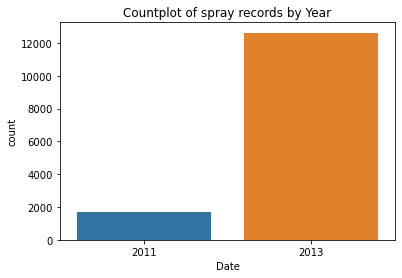

In [ ]:
g = sns.countplot(x=spray_cleaned.loc[:,'Date'].dt.year)
plt.title('Countplot of spray records by Year')
plt.show()

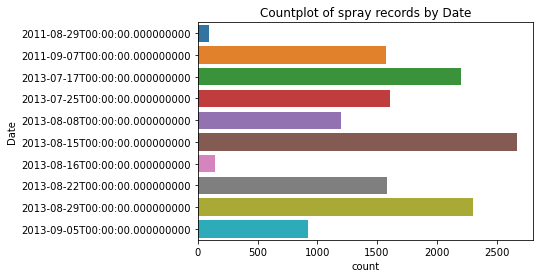

In [ ]:
g = sns.countplot(y=spray_cleaned.loc[:,'Date'])
plt.title('Countplot of spray records by Date')
plt.show()

Above plots shows that spray dataset contains records for years 2011 and 2013. Only 10 such dates are avaiable across both years.

### Inspect timeframe covered by train dataset

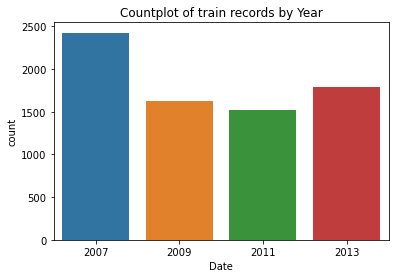

In [ ]:
g = sns.countplot(x=train_weather.loc[:,'Date'].dt.year)
plt.title('Countplot of train records by Year')
plt.show()

Records in train dataset cover 4 alternate years, starting from 2007. The spray data would be applicable for combining with the train records in 2011 and 2013.

### Inspect timeframe covered by test dataset

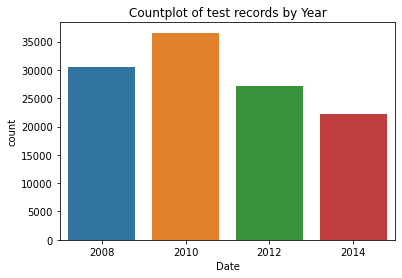

In [ ]:
g = sns.countplot(x=test_cleaned.loc[:,'Date'].dt.year)
plt.title('Countplot of test records by Year')
plt.show()

Records in test dataset cover 4 alternate years too, starting from 2008 and is mutually exclusive with the years covered in the train dataset. Unfortunately, none of the spray records would be applicable to the test dataset, so there is no basis for combining spray information with test records.

### Create 7 / 14-day rolling spray data at different distances

In [ ]:
rolling_days_list = [7, 14]
dist_value_list = [25, 50, 75]

train_weather_spray = train_weather

# WARNING: EXTREMELY SLOW OPERATION
for days_value in rolling_days_list:
    for dist_value in dist_value_list:
        print('Generating spray data for rolling {}-day at {} meters'.format(days_value, dist_value))
        train_weather_spray = train_weather_spray.apply(get_spray_count_in_proximity, args=(days_value, dist_value, ), axis=1)
        # save interim captured data
        train_weather_spray.to_csv('../assets/train_weather_spray_v2_combined.csv', index=False)

Generating spray data for rolling 7-day at 25 meters
Generating spray data for rolling 7-day at 50 meters
Generating spray data for rolling 7-day at 75 meters
Generating spray data for rolling 14-day at 25 meters
Generating spray data for rolling 14-day at 50 meters
Generating spray data for rolling 14-day at 75 meters


In [ ]:
train_weather_spray

,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,NumMosquitos_sum,species_culex_erraticus,...,CodeSum_RA_sum_past21day,CodeSum_TSRA_sum_past21day,CodeSum_DZ_sum_past21day,data_availability_for_21_days,sp_count_past_7_days_25_meters,sp_count_past_7_days_50_meters,sp_count_past_7_days_75_meters,sp_count_past_14_days_25_meters,sp_count_past_14_days_50_meters,sp_count_past_14_days_75_meters
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0,0,...,7,1,0,21,0,0,0,0,0,0
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,1.0,0,...,7,1,0,21,0,0,0,0,0,0
2,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0,1.0,0,...,7,1,0,21,0,0,0,0,0,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0,1.0,0,...,7,1,0,21,0,0,0,0,0,0
4,2007-05-29,CULEX RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0,4.0,0,...,7,1,0,21,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7365,2013-09-26,CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,41.763733,-87.742302,1,6.0,0,...,2,0,1,21,0,0,0,0,0,0
7366,2013-09-26,CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,41.987280,-87.666066,0,5.0,0,...,2,0,1,21,0,0,0,0,0,0
7367,2013-09-26,CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,41.912563,-87.668055,0,1.0,0,...,2,0,1,21,0,0,0,0,0,0
7368,2013-09-26,CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,42.009876,-87.807277,0,5.0,0,...,3,1,0,21,0,0,0,0,0,0


### Creating

# Inspect and save combined data

## Process train dataset

In [ ]:
train_weather_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7370 entries, 0 to 7369
Data columns (total 85 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             7370 non-null   datetime64[ns]
 1   Species                          7370 non-null   object        
 2   Block                            7370 non-null   int64         
 3   Street                           7370 non-null   object        
 4   Trap                             7370 non-null   object        
 5   Latitude                         7370 non-null   float64       
 6   Longitude                        7370 non-null   float64       
 7   WnvPresent                       7370 non-null   int64         
 8   NumMosquitos_sum                 7370 non-null   float64       
 9   species_culex_erraticus          7370 non-null   int64         
 10  species_culex_pipiens            7370 non-null   int64      

From above dataframe information, columns 0 to 16 correspond to the original trap data records in train dataset.

Columns 17 to 20 are engineered from *Date* column in train dataset to aid plotting in Exploratory Data Analysis phase.

Column 21 was created to facilitate joining of weather and train datasets.

Columns 22 to 54 encompass same-day weather information that is tied to the trap record that is generated for a given date.

Columns 55 to 78 encompass the historical weather data, i.e. 7/14/21 rolling day aggregation of weather effects. Columns 64, 74 and 78 (data_availability_for_7_days, data_availability_for_14_days, data_availability_for_21_days) indicate the number of days in which weather data was available, as a gauge of how representative the historical weather data is for a given trap record.

Columns 79 to 84 encompass the historical spray data, i.e. 7/14 rolling day aggregation of nearby sprays, defined by distance values 25, 50m and 75m.

In [ ]:
train_weather_spray.to_csv('../assets/train_weather_spray_combined.csv', index=False)

## Process test dataset

In [ ]:
test_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 79 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Id                              116293 non-null  int64         
 1   Date                            116293 non-null  datetime64[ns]
 2   Species                         116293 non-null  object        
 3   Block                           116293 non-null  int64         
 4   Street                          116293 non-null  object        
 5   Trap                            116293 non-null  object        
 6   Latitude                        116293 non-null  float64       
 7   Longitude                       116293 non-null  float64       
 8   AddressAccuracy                 116293 non-null  int64         
 9   species_culex_erraticus         116293 non-null  int64         
 10  species_culex_pipiens           116293 non-null  int64  

Combined test dataset has 6 less columns than combined train dataset due to the lack of relevant spray data for the years covered in test dataset.

In [ ]:
test_weather.to_csv('../assets/test_weather_combined.csv', index=False)

Combined train dataset is <b>train_weather_spray_combined.csv</b>, while combined test dataset is <b>test_weather_combined.csv</b>.